In [1]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
import os, random
import time
from PIL import Image
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import cv2
import timm
from sklearn.metrics import accuracy_score

# Loading model

In [2]:
#TIMM_MODEL = 'tf_efficientnet_b3' #b3 imagenet
#TIMM_MODEL = 'tf_efficientnet_b4_ns' #b4 noisy student
TIMM_MODEL = 'tf_efficientnet_b3_ns' #b3 noisy student 
class CassavaNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = timm.create_model(TIMM_MODEL, pretrained=True)
        #n_features = backbone.classifier.in_features
        self.backbone = nn.Sequential(*backbone.children())[:-2]
        #self.classifier = nn.Linear(1536, 5)
        self.classifier = nn.Sequential(backbone.classifier)
        self.classifier.add_module('7', nn.ReLU())
        self.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
        self.classifier.add_module('9', nn.Linear(1000, 5))
        #self.classifier.add_module('10', nn.LogSoftmax(dim=1))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.pool(feats).view(x.size(0), -1)
        x = self.classifier(x)
        return x, feats

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
model = CassavaNet()

for module in model.modules():
    # print(module)
    if isinstance(module, nn.BatchNorm2d):
        if hasattr(module, 'weight'):
            module.weight.requires_grad_(False)
        if hasattr(module, 'bias'):
            module.bias.requires_grad_(False)
        module.eval()
            
model.to(device)

CassavaNet(
  (backbone): Sequential(
    (0): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
 

# Train

In [4]:
class CassavaDataset(torch.utils.data.Dataset):
    """Cassava dataset."""

    def __init__(self, dataframe, root_dir, transforms=None):
        """
        Args:
            dataframe (string): dataframe train/valid
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super().__init__()
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)
    
    def get_img_bgr_to_rgb(self, path):
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        return im_rgb

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = self.get_img_bgr_to_rgb(img_name)
        if self.transforms:
            image = self.transforms(image=image)['image']
        csv_row = self.dataframe.iloc[idx, 1:]
        sample = {
            'image': image, 
            'label': csv_row.label,
        }
        return sample

In [5]:
DATA_PATH = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
NUM_FOLDS = 5
bs = 4
# Running only 5 epochs to test (Train more offline ^_^)
EPOCHS = 30
sz = 512
SNAPMIX_ALPHA = 5.0
SNAPMIX_PCT = 0.
GRAD_ACCUM_STEPS = 1


#norm try with mean=[0.4580, 0.5274, 0.3245], std=[0.2267, 0.2285, 0.2170] too
def train_transforms():
    return Compose([
            A.RandomResizedCrop(sz, sz),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.2),
            A.ShiftScaleRotate(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


def valid_transforms():
    return Compose([
            A.Resize(sz, sz),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 1234
seed_everything(SEED)   

In [7]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def get_spm(input,target,model):
    imgsize = (sz, sz)
    bs = input.size(0)
    with torch.no_grad():
        output,fms = model(input)
        clsw = model.classifier
        weight = clsw[-1].weight.data
        bias = clsw[-1].bias.data
        weight = weight.view(weight.size(0),weight.size(1),1,1)
        fms = F.relu(fms)
        poolfea = F.adaptive_avg_pool2d(fms,(1,1)).squeeze()
        clslogit = F.softmax(clsw.forward(poolfea))
        logitlist = []
        for i in range(bs):
            logitlist.append(clslogit[i,target[i]])
        clslogit = torch.stack(logitlist)

        out = F.conv2d(fms, weight, bias=bias)

        outmaps = []
        for i in range(bs):
            evimap = out[i,target[i]]
            outmaps.append(evimap)

        outmaps = torch.stack(outmaps)
        if imgsize is not None:
            outmaps = outmaps.view(outmaps.size(0),1,outmaps.size(1),outmaps.size(2))
            outmaps = F.interpolate(outmaps,imgsize,mode='bilinear',align_corners=False)

        outmaps = outmaps.squeeze()

        for i in range(bs):
            outmaps[i] -= outmaps[i].min()
            outmaps[i] /= outmaps[i].sum()


    return outmaps,clslogit

def snapmix(input, target, alpha, model=None):

    r = np.random.rand(1)
    lam_a = torch.ones(input.size(0))
    lam_b = 1 - lam_a
    target_b = target.clone()

    if True:
        wfmaps,_ = get_spm(input, target, model)
        bs = input.size(0)
        lam = np.random.beta(alpha, alpha)
        lam1 = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(bs).cuda()
        wfmaps_b = wfmaps[rand_index,:,:]
        target_b = target[rand_index]

        same_label = target == target_b
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        bbx1_1, bby1_1, bbx2_1, bby2_1 = rand_bbox(input.size(), lam1)

        area = (bby2-bby1)*(bbx2-bbx1)
        area1 = (bby2_1-bby1_1)*(bbx2_1-bbx1_1)

        if  area1 > 0 and  area>0:
            ncont = input[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
            ncont = F.interpolate(ncont, size=(bbx2-bbx1,bby2-bby1), mode='bilinear', align_corners=True)
            input[:, :, bbx1:bbx2, bby1:bby2] = ncont
            lam_a = 1 - wfmaps[:,bbx1:bbx2,bby1:bby2].sum(2).sum(1)/(wfmaps.sum(2).sum(1)+1e-8)
            lam_b = wfmaps_b[:,bbx1_1:bbx2_1,bby1_1:bby2_1].sum(2).sum(1)/(wfmaps_b.sum(2).sum(1)+1e-8)
            tmp = lam_a.clone()
            lam_a[same_label] += lam_b[same_label]
            lam_b[same_label] += tmp[same_label]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            lam_a[torch.isnan(lam_a)] = lam
            lam_b[torch.isnan(lam_b)] = 1-lam

    return input,target,target_b,lam_a.cuda(),lam_b.cuda()

In [8]:
def accuracy_metric(input, targs):
    return accuracy_score(targs.cpu(), input.cpu())

def print_scores(scores):
    kaggle_metric = np.average(scores)
    print("Kaggle Metric: %f" % (kaggle_metric))
    
    return kaggle_metric

In [9]:
def checkpoint(model, optimizer, epoch, current_metric, best_metric, fold):
    print("Metric improved from %f to %f , Saving Model at Epoch #%d" % (best_metric, current_metric, epoch))
    ckpt = {
        'model': CassavaNet(),
        'state_dict': model.state_dict(),
        #'optimizer' : optimizer.state_dict(),  # Commenting this out to cheap out on space
        'metric': current_metric
    }
    torch.save(ckpt, '/media/sergio/traballos sergio/msi/models/cassava/ckpt_%s-%d-%f-snap=0-extra.pth' % (TIMM_MODEL, sz, current_metric))

In [10]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

In [11]:
class SnapMixLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, t1, t2, ls,  ya, yb, lam_a, lam_b):
        loss_a = bi_tempered_logistic_loss(outputs, ya, t1, t2, ls)
        loss_b = bi_tempered_logistic_loss(outputs, yb, t1, t2, ls)
        loss = torch.mean(loss_a * lam_a + loss_b * lam_b)
        return loss

In [12]:
#All data
train_df = pd.read_csv(DATA_PATH + "train_extra.csv")
train_df

In [25]:
#initial data
train_df = pd.read_csv(DATA_PATH + "train.csv")
train_df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [ ]:
mean, std = cv2.meanStdDev(img)

In [14]:
folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, 
                        random_state=SEED).split(np.arange(train_df.shape[0]), 
                                                 train_df.label.values)

In [ ]:
for fold_num, (train_split, valid_split) in enumerate(folds):
    train_set = train_df.iloc[train_split].reset_index(drop=True)
    valid_set = train_df.iloc[valid_split].reset_index(drop=True)
    
    train_ds = CassavaDataset(dataframe=train_set,
                          root_dir='/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/',
                          transforms=train_transforms())
    
    valid_ds = CassavaDataset(dataframe=valid_set,
                          root_dir='/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/',
                          transforms=valid_transforms())
    
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, 
                                           shuffle=True, num_workers=8, drop_last=True,
                                           pin_memory=True)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=4, 
                                           shuffle=False, num_workers=8, 
                                           pin_memory=True)
    
    losses = []
    batches = len(train_dl)
    val_batches = len(valid_dl)
    best_metric = 0
    
    #model = CassavaNet().to(device)
    t1 = 1.0
    t2 = 1.0
    ls = 0.05
    #criterion = nn.CrossEntropyLoss(reduction='none').to(device)
    #criterion = bi_tempered_logistic_loss()
    #val_criterion = nn.CrossEntropyLoss().to(device)
    #val_criterion = bi_tempered_logistic_loss()
    snapmix_criterion = SnapMixLoss().to(device)
    param_groups = [
       {'params': model.backbone.parameters(), 'lr': 0.1e-2},
       {'params': model.classifier.parameters()},
    ]
    optimizer = torch.optim.SGD(param_groups, lr=0.1e-1, momentum=0.9,
                                weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,20,40], 
                                                     gamma=0.1, last_epoch=-1, verbose=True)
    scaler = GradScaler()
    
    for epoch in range(EPOCHS):
        # ----------------- TRAINING  ----------------- 
        train_loss = 0
        progress = tqdm(enumerate(train_dl), desc="Loss: ", total=batches)

        model.train()
        for i, data in progress:
            image, label = data.values()
            X, y = image.to(device).float(), label.to(device).long()
            
            with autocast():
                
                rand = np.random.rand()
                if rand > (1.0-SNAPMIX_PCT):
                    X, ya, yb, lam_a, lam_b = snapmix(X, y, SNAPMIX_ALPHA, model)
                    outputs, _ = model(X)
                    loss = snapmix_criterion(outputs, t1, t2, ls, ya, yb, lam_a, lam_b).to(device)
                else:
                    outputs, _ = model(X)
                    loss = torch.mean(bi_tempered_logistic_loss(outputs, y, t1, t2, ls).to(device))
                
            scaler.scale(loss).backward()
            # Accumulate gradients
            if ((i + 1) % GRAD_ACCUM_STEPS == 0) or ((i + 1) == len(train_dl)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            train_loss += loss.item()
            cur_step = i+1
            trn_epoch_result = dict()
            trn_epoch_result['Epoch'] = epoch + 1
            trn_epoch_result['train_loss'] = round(train_loss/cur_step, 4)

            progress.set_description(str(trn_epoch_result))

        scheduler.step()
        #if torch.cuda.is_available():
        torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        val_loss = 0
        scores = []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_dl):
                image, label = data.values()
                X, y = image.to(device), label.to(device)
                outputs, _ = model(X)
                l = bi_tempered_logistic_loss(outputs, y, t1, t2, ls).to(device)
                val_loss += l.item()

                preds = F.softmax(outputs).argmax(axis=1)
                scores.append(accuracy_metric(preds, y))

        epoch_result = dict()
        epoch_result['Epoch'] = epoch + 1
        epoch_result['train_loss'] = round(train_loss/batches, 4)
        epoch_result['val_loss'] = round(val_loss/val_batches, 4)

        print(epoch_result)

        # Check if we need to save
        current_metric = print_scores(scores)
        if current_metric > best_metric and current_metric > 0.85:
            checkpoint(model, optimizer, epoch+1, current_metric, best_metric, fold_num)
            best_metric = current_metric
            
    del model, optimizer, train_dl, valid_dl, scaler, scheduler
    torch.cuda.empty_cache()
    
    # Train only a single fold
    break

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-02.


{'Epoch': 1, 'train_loss': 0.6676}: 100%|██████████| 5410/5410 [15:34<00:00,  5.79it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 1 to 1.0000e-03.



<ipython-input-15-bd041b10f901>:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(outputs).argmax(axis=1)


{'Epoch': 1, 'train_loss': 0.6676, 'val_loss': 0.4858}
Kaggle Metric: 0.820030


{'Epoch': 2, 'train_loss': 0.4691}: 100%|██████████| 5410/5410 [16:07<00:00,  5.59it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 1 to 1.0000e-03.


{'Epoch': 2, 'train_loss': 0.4691, 'val_loss': 0.4471}
Kaggle Metric: 0.839985


{'Epoch': 3, 'train_loss': 0.4369}:  71%|███████▏  | 3861/5410 [11:28<05:09,  5.01it/s]

### Extra csv

In [12]:
train = pd.read_csv(DATA_PATH +'train.csv')
old_imgs = [f'train_images/{img}' for img in train['image_id'].values]
old_labs = train['label'].tolist()

len(old_imgs), len(old_labs)

(21397, 21397)

In [12]:
extra_labels = os.listdir('/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/extra/train')
map2labs = {
    'cbb': 0,
    'cbsd': 1,
    'cgm': 2,
    'cmd': 3, 
    'healthy': 4
}
new_imgs, new_labs = [] ,[]
for lab in extra_labels:
    imgs = os.listdir('/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/extra/train/'+ lab)
    new_imgs += [f'extra/train/{lab}/{img}' for img in imgs]
    new_labs += [map2labs[lab]]*len(imgs)
    
len(new_imgs), len(new_labs)

(5656, 5656)

In [13]:
train_extra = pd.DataFrame({
    'image_id': old_imgs + new_imgs,
    'label': old_labs + new_labs
})

In [14]:
train_df = train_extra
train_df

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3
...,...,...
27048,extra/train/healthy/train-healthy-22.jpg,4
27049,extra/train/healthy/train-healthy-220.jpg,4
27050,extra/train/healthy/train-healthy-221.jpg,4
27051,extra/train/healthy/train-healthy-222.jpg,4


In [17]:
train_df.to_csv(DATA_PATH +'train_extra.csv', index=False)

# Results

In [30]:
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
n_classes = 5
files_path = f'{database_base_path}test_images/'
test_size = len(os.listdir(files_path))
test_preds = np.zeros((test_size, n_classes))
loader = torchvision.transforms.Compose([
        torchvision.transforms.Resize(512),
        torchvision.transforms.CenterCrop(448),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_names =  os.listdir(files_path)

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def prediction(model, files_path):
    labels = []
    for img in os.listdir(files_path):
        image = image_loader(files_path + img)
        model.eval()
        with torch.no_grad():
            pred, _ = model(image.cuda())
            print(pred.shape)
            label = torch.argmax(pred)
            labels.append(label.item())
    return np.array(labels) 

test_preds = prediction(model, files_path)
test_preds


torch.Size([1, 5])


array([4])

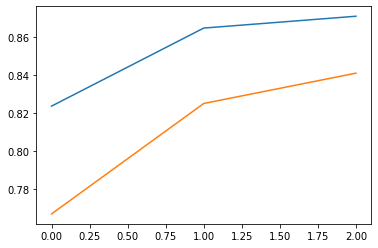

In [13]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

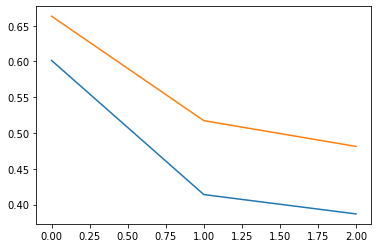

In [14]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [10]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2.h5'
torch.save(model, PATH)

In [ ]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2-best.h5'
torch.save(best_model, PATH)

In [19]:
model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
images: 1000
0 Loss: 0.4861 Acc: 0.8330
1 Loss: 0.3932 Acc: 0.8623

Epoch 1/1
----------
images: 1000
0 Loss: 0.4753 Acc: 0.8360
1 Loss: 0.4009 Acc: 0.8617

Training complete in 27m 41s
Best val Acc: 0.862305
train loss: [0.4860530502452251, 0.47531284963301507]

val loss: [0.3931747988661362, 0.4008864563196387]

train acc: [0.8329576070819816, 0.8359817452026173]

val acc: [0.8623052959501558, 0.8616822429906542]


# Semi-train 

In [4]:
#Data transformations for data augmentation
jitter_param = 0.3
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-30,30), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values

train_val_split = 0.85
batch_size = 6

train_dataset = Dataset(imgs[0:700], 
                        labels[0:700], 
                        train_transform)
val_dataset = Dataset(imgs[1000:1500], 
                      labels[1000:1500], 
                      val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.75)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
0 Loss: 1.4239 Acc: 0.4914
1 Loss: 1.1418 Acc: 0.6260

Epoch 1/4
----------
0 Loss: 1.2096 Acc: 0.5743
1 Loss: 1.0764 Acc: 0.6260

Epoch 2/4
----------
0 Loss: 1.1282 Acc: 0.5800
1 Loss: 1.0208 Acc: 0.6500

Epoch 3/4
----------


KeyboardInterrupt: 

In [ ]:
last acc: [0.87507] resnet